# Principle of virtual work

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sKujirai/nlfepy/blob/master/notebook/example_pvw.ipynb)

## Theory

### Governing equation
The principle of virtual work, the governing equation of infinitesimal deformation problems, is written as follows, 
$$
\int_{\mathscr{V}} \boldsymbol{T} \cdot \breve{\boldsymbol{E}} \mathrm{d}v
= \oint_{\mathscr{S}} \mathop{\boldsymbol{t}}^{\scriptscriptstyle{(n)}} \cdot \breve{u} \mathrm{d}a
+ \int_{\mathscr{V}} \rho \boldsymbol{f} \cdot \breve{u} \mathrm{d} v.
$$

- $\boldsymbol{T}$: the Cauchy stress tensor
- $\breve{\boldsymbol{E}}$: the virtual strain tensor
- $\displaystyle{\mathop{\boldsymbol{t}}^{\scriptscriptstyle{(n)}}}$: the traction vector
- $\breve{\boldsymbol{u}}$: the virtual displacement vector
- $\boldsymbol{f}$: the body force vector

### Discretization
The discretized version of the principle of virtual work is  expressed as
$$
\int_{\mathscr{V}^{\mathrm{E}}} \left[ \boldsymbol{B} \right]^{\mathrm{T}} \left[ \boldsymbol{C}^{\mathrm{e}} \right] \left[ \boldsymbol{B} \right] \mathrm{d}v \{ \boldsymbol{u}^{I} \}
= \oint_{\mathscr{S}^{\mathrm{E}}} \left[ \boldsymbol{N} \right]^{\mathrm{T}} \{ \mathop{\boldsymbol{t}}^{\scriptscriptstyle{(n)}} \} \mathrm{d}a
+ \int_{\mathscr{V}^{\mathrm{E}}} \left[ \boldsymbol{N} \right]^{\mathrm{T}} \{ \boldsymbol{f} \} \mathrm{d}v.
$$

- $[ \boldsymbol{N} ]$: the shape function matrix
- $[ \boldsymbol{B} ]$: is the B matrix, the first derivative of the shape function
- $[\boldsymbol{C}^{\mathrm{e}}]$: the elastic modulus matrix
- $\{ \boldsymbol{u}^{I} \} $: the displacement vector of node $I$

The above equation is written as the element stiffness equation form as
$$
[ \boldsymbol{k}^{\mathrm{E}} ] \{ \boldsymbol{u}^{I} \} = \{ \boldsymbol{f} \}.
$$

- $[ \boldsymbol{k}^{\mathrm{E}} ]$: The element stiffness matrix
$$
[ \boldsymbol{k}^{\mathrm{E}} ] = \int_{\mathscr{V}^{\mathrm{E}}} \left[ \boldsymbol{B} \right]^{\mathrm{T}} \left[ \boldsymbol{C}^{\mathrm{e}} \right] \left[ \boldsymbol{B} \right] \mathrm{d}v
$$

- $\{ \boldsymbol{f} \} $: The element force vector
$$
\{ \boldsymbol{f} \} = \oint_{\mathscr{S}^{\mathrm{E}}} \left[ \boldsymbol{N} \right]^{\mathrm{T}} \{ \mathop{\boldsymbol{t}}^{\scriptscriptstyle{(n)}} \} \mathrm{d}a + \int_{\mathscr{V}^{\mathrm{E}}} \left[ \boldsymbol{N} \right]^{\mathrm{T}} \{ \boldsymbol{f} \} \mathrm{d}v
$$

## Finite element analysis

### Set up

In [ ]:
# Install nlfepy
! pip install git+https://github.com/sKujirai/nlfepy

  Cloning https://github.com/sKujirai/nlfepy to /tmp/pip-req-build-lp6usboq
  Running command git clone -q https://github.com/sKujirai/nlfepy /tmp/pip-req-build-lp6usboq
  Created wheel for nlfepy: filename=nlfepy-0.1.0-cp36-none-any.whl size=40057 sha256=a14ff4aa55bbafbab3f9857d8ce2931b4019f06659d9c03e67b040c72bb391fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-u978lgxv/wheels/59/26/c7/b8c237166dc06e8e18ca3e8fab51a3525cabffe8e97c8cfbcb
Successfully built nlfepy


### Generate mesh (or read your mesh file)

In [ ]:
# Install dmsh to generate mesh
! pip install dmsh

     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 153kB 8.8MB/s 


In [ ]:
# Generate mesh
import dmsh

geo = dmsh.Rectangle(0., 1., 0., 1.)
coords, connectivity = dmsh.generate(geo, 0.1)

/usr/local/lib/python3.6/dist-packages/meshplex/mesh_tri.py:1137: UserWarning: Maximum number of edge flips reached. Smallest ce-ratio: -1.410e-12.
  f"Maximum number of edge flips reached. Smallest ce-ratio: {m:.3e}."


### Mesh class

In [ ]:
from nlfepy import Mesh

# Generate mesh class
mesh = Mesh()

# Set mesh shape
mesh.set_shape(coords=coords.T, connectivity=connectivity)

# Apply boundary conditions
mesh.set_bc(constraint='compression', value=0.001)

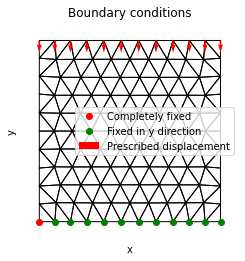

In [ ]:
# Check boundary consitions
from nlfepy import Viewer

# Instantiate viewer class
viewer = Viewer()
viewer.plot_bc(mesh)

### Set material

In [ ]:
from nlfepy import Material

# Select aluminium
mater = Material('Al')

### Select constitutive equation (relation between stress and strain specific to material)

In [ ]:
from nlfepy import Variable, Constitutive

# Physical quantities
vals = Variable()

# Set constitutive
constitutive = Constitutive(
    mater,
    nitg=mesh.n_tintgp,
    val=vals['itg']
)

### Solve the governing equation

In [ ]:
from nlfepy.interface import PVW

# Select principle of virtual work
pvw = PVW(
    mesh=mesh,
    cnst=constitutive,
    val=vals['point']
)

# Solve KU=F
pvw.solve()

In [ ]:
from nlfepy.util import calc_element_value

# Calc. stress (optional)
pvw.calc_stress()

# Calc. element values (for output)
calc_element_value(mesh=mesh, values=vals)

### Show result

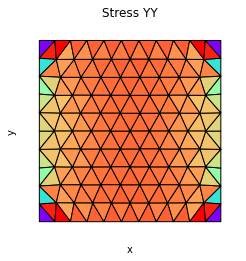

In [ ]:
# Plot the distribution of stress Tyy
viewer.plot(
    mesh=mesh,
    val=vals['element']['stress'][:, 1],
    title='Stress YY',
)

# Save as .png format
viewer.save('result.png', transparent=True, dpi=300)

/usr/local/lib/python3.6/dist-packages/nlfepy/io/viewer2d.py:336: UserWarning: The following kwargs were not used by contour: 'title'
  self._pcm = self._ax.tricontourf(triang, value, **kwargs)


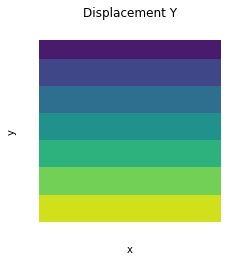

In [ ]:
# Contour plot (for 2D)

viewer.contour(
    mesh=mesh,
    val=vals['point']['u_disp'][1],
    title='Displacement Y'
)

### Save result as [VTK XML Formats](https://www.vtk.org/Wiki/VTK_XML_Formats)

In [ ]:
from nlfepy.io import VtuWriter

writer = VtuWriter(mesh=mesh, values=vals)
writer.write('result.vtu') 